(dl/01-intro)=
# Introduction to Neural Networks

Deep learning models are machine learning models with multiple layers of *learned representations*. A **layer** refers to any transformation that maps an input to its feature representation. In principle, any function that can be described as a composition of layers with *differentiable operations* is called a **neural network**.  Representations are powerful. In machine translation, sentences are not translated word-for-word between two languages. Instead, a model learns an intermediate representation that captures the 'thought' shared by the translated sentences ({numref}`01-thought`).

<br>

```{figure} ../../img/nn/01-thought.png
---
name: 01-thought
width: 80%
---
Thought is a representation.
```

The practical successes of deep learning can be attributed to three factors:

- **Scalability.** Deep neural networks ({numref}`01-imagenet-progress`) are created by stacking multiple layers (10-100+). Features at deep layers can be thought of as combinatorial, higher-level, and less sensitive to noise, thereby improving generalization. On the other hand, *wider layers*, i.e. layers with more parameters, memorizes features better at that level. There are tradeoffs with depth and width that has to be controlled in order to get effectively sized networks. But in general, the larger the network, the better it generalizes to test data.

+++

- **Massive datasets.** Deep large networks ({numref}`01-imagenet-progress`) are necessary for tasks involving massive, complex, structured datasets like images and text, where the complexity of the model aligns with that of the underlying distributions in the data. Moreover, complex models allow for *automatic feature engineering*, provided that prior knowledge about the structure (or [modality](https://en.wikipedia.org/wiki/Multimodal_learning)) of the data is encoded into the network architecture. Another interesting property of neural networks is that knowledge can be transferred between tasks through **transfer learning** where are a large model pre-trained on a large dataset can be adapted to specialized tasks using smaller datasets. 

+++

- **Compute.** Both of these factors require significant computational resources ({numref}`01-gflops`). GPUs are particularly well-suited for the large scale matrix operations required in deep learning with their parallel processing capabilities.

```{figure} ../../img/nn/01-imagenet-progress.png
---
name: 01-imagenet-progress
width: 80%
---
Progress in top-5 error in the [ImageNet competition](https://en.wikipedia.org/wiki/ImageNet#ImageNet_Challenge).
```

```{figure} ../../img/nn/01-gflops.png
---
name: 01-gflops
width: 80%
---
ResNets are in the middle of the graph. GFlops are a good metric since a network can have large compute with small number of parameters (e.g. convolutions).
```

## References

- https://cs182sp21.github.io/static/slides/lec-1.pdf
- https://cs182sp21.github.io/static/slides/lec-2.pdf
- https://cs182sp21.github.io/static/slides/lec-3.pdf
- https://www.cs.cornell.edu/courses/cs4780/2018sp/lectures/lecturenote12.html
- {cite}`data-programming`

### Experiments

In [18]:
x = torch.linspace(-10, 10, 1000)
y = 3 * torch.sin(x) + torch.cos(torch.pi * x)


def model(width, sample_size, alpha=0.0, x=x, y=y):
    """Fitting a wide fully connected ReLU network."""
    
    x = x.reshape(-1, 1)
    y = y.reshape(-1, 1)
    N = torch.randint(0, 1000, size=(sample_size,))
    N = torch.sort(N)[0]
    xs = x[N]
    ys = y[N]

    net = nn.Sequential(
        nn.Linear(1, width),
        nn.Tanh(),
        nn.Linear(width, 1)
    )
    theta = net.parameters()
    optim = torch.optim.Adam(theta, lr=0.1, weight_decay=alpha)

    for _ in range(100):
        loss = F.mse_loss(ys, net(xs))
        loss.backward()
        optim.step()
        optim.zero_grad()

    return net(x).reshape(-1).detach().cpu().numpy()


def variance(sample_preds):
    p_bar = sum(sample_preds) / len(sample_preds)
    return sum([((p_bar - p) ** 2).mean() for p in sample_preds]) / len(sample_preds)

def bias(sample_preds):
    p_bar = sum(sample_preds) / len(sample_preds)
    return ((p_bar - y.numpy()) ** 2).mean()

Decreasing model complexity decreases variance:

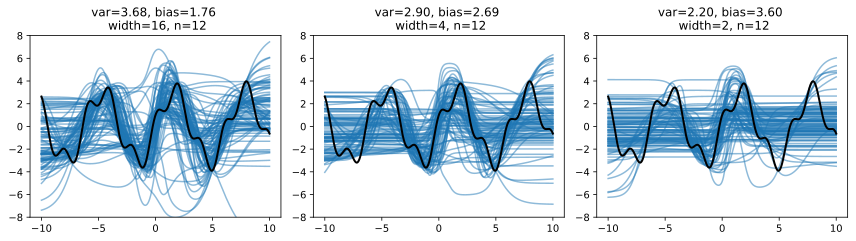

In [19]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

def reset_seed():
    np.random.seed(0)
    torch.manual_seed(0)

def plot_model(ax, width=6, sample_size=6, alpha=0.0, count=300):
    sample_preds = []
    for i in range(count):
        p = model(width, sample_size, alpha)
        if i < 100:
            ax.plot(x, p, alpha=0.5, color="C0")
        sample_preds.append(p)
    
    var = variance(sample_preds)
    b = bias(sample_preds)

    title = f"var={var:.2f}, bias={b:.2f} \n width={width}, n={sample_size}"
    if alpha > 0:
        title += f", $\lambda$={alpha:.0e}"
    
    ax.set_title(title)
    ax.plot(x, y, color="black", linewidth=2)
    ax.set_ylim(-8, 8)


reset_seed()
fig, ax = plt.subplots(1, 3, figsize=(12, 3.5))
plot_model(ax[0], width=16, sample_size=12)
plot_model(ax[1], width=4,  sample_size=12)
plot_model(ax[2], width=2,  sample_size=12)
fig.tight_layout()

Regularization decreases variance and increases bias:

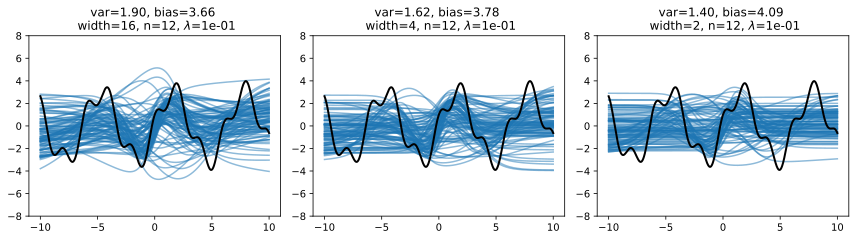

In [20]:
reset_seed()
fig, ax = plt.subplots(1, 3, figsize=(12, 3.5))
plot_model(ax[0], width=16, sample_size=12, alpha=0.1)
plot_model(ax[1], width=4,  sample_size=12, alpha=0.1)
plot_model(ax[2], width=2,  sample_size=12, alpha=0.1)
fig.tight_layout()

More data decreases variance so that bias dominates:

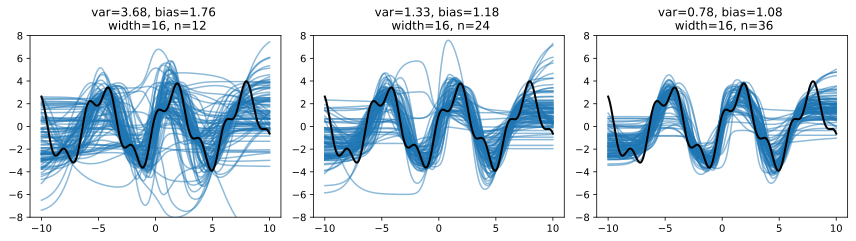

In [21]:
reset_seed()
fig, ax = plt.subplots(1, 3, figsize=(12, 3.5))
plot_model(ax[0], width=16, sample_size=12)
plot_model(ax[1], width=16, sample_size=24)
plot_model(ax[2], width=16, sample_size=36)
fig.tight_layout()

Regularization when too strong can make low complexity models underfit:

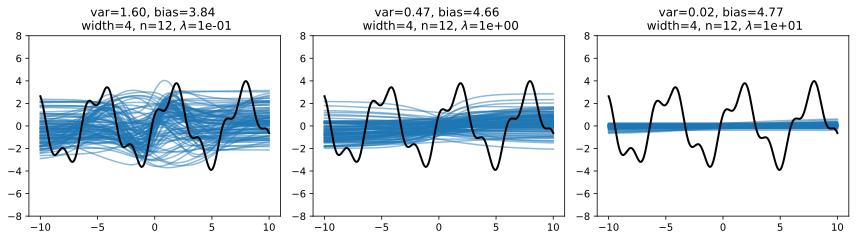

In [22]:
reset_seed()
fig, ax = plt.subplots(1, 3, figsize=(12, 3.5))
plot_model(ax[0], width=4, sample_size=12, alpha=0.1)
plot_model(ax[1], width=4, sample_size=12, alpha=1.0)
plot_model(ax[2], width=4, sample_size=12, alpha=10.0)
fig.tight_layout()

**Remark.** Notice that complex models benefit more with regularization and scale better with data compared to simple models. The experiments show that starting with complex models followed by regularization is a valid approach.

### Train-validation split

How do we know if we are overfitting or underfitting? Note that we do not have access to the
ground truth function $f$ (otherwise there is no point in doing ML) or the expected model
$\bar{f}$ (too expensive to estimate). How do we select algorithm or hyperparameters? 
This
can be done simply by reserving a subset of the dataset called the **validation set** for
estimating the true risk. The validation performance is used for choosing hyperparameters and tweaking the model class. Recall that the training dataset is used to minimize the empirical risk. In terms of train and validation loss:

* Overfitting is characterized by significant $\mathcal{L}_{\mathcal{D}_{\text{train}}}(\boldsymbol{\Theta}) \ll \mathcal{L}_{\mathcal{D}_{\text{val}}}(\boldsymbol{\Theta})$. 
* Underfitting is characterized by $\mathcal{L}_{\mathcal{D}_{\text{train}}}(\boldsymbol{\Theta})$ not decreasing low enough ({numref}`01-train-valid-curve`).

The training and validation curves are generated by $(t, \mathcal{L}_{\mathcal{D}_{\text{train}}}(\boldsymbol{\Theta}^t))$ and $(t, \mathcal{L}_{\mathcal{D}_{\text{val}}}(\boldsymbol{\Theta}^t))$ for steps $t$ during training ({numref}`01-train-valid-curve`). The model only sees the train set during training. Meanwhile, the model is evaluated on the same validation set getting controlled results. Note that modifying training hyperparameters between runs means that the validation set is now being overfitted. Techniques such as [k-fold cross-validation](https://machinelearningmastery.com/k-fold-cross-validation/) or mitigates this, but can be expensive for training large models.
Training ends with a final set of parameters $\hat{\boldsymbol{\Theta}}.$

Finally, a separate **test set** is used to report the final performance. The loss 
on the test set $\mathcal{L}_{\mathcal{D}_{\text{test}}}(\hat{\boldsymbol{\Theta}})$ acts as the final estimate of the true risk of the trained model. It is best practice that the test evaluation is done exactly once. Note that the training, validation, and test sets are chosen to be disjoint.

**Remarks.** Regularization tends to flatten out the classical U-shape validation curve that occurs before epoch-wise double descent ({numref}`01-double-descent-epochs`) where the model overfits. Assuming the model is sufficiently complex so that there is little bias, underfitting can indicate a problem with the optimizer (e.g. learning rate). We will see in the next chapter that training loss curves stuck to values away from zero may indicate a problem with the optimizer (stuck in a plateau, or bad local optima).

<br>

```{figure} ../../img/nn/01-train-valid-curve.png
---
name: 01-train-valid-curve
width: 70%
---
Train and validation loss curves during training. Gap in train curve can indicate bias
or a problem with the optimizer.
Source: [[CS182-lec3]](https://cs182sp21.github.io/static/slides/lec-3.pdf)
```

```{figure} ../../img/nn/01-canonical-loss.png
---
name: 01-canonical-loss
width: 85%
---
Canonical train-validation loss curves. Source: {cite}`keras2`
```

**Remark.** A commonly used technique is **early stopping** which stops training once the validation curves stops improving after a set number of steps. One consequence of epoch-wise double descent is that early stopping only helps in the relatively narrow parameter regime of critically parameterized models ({numref}`01-double-descent-epochs`)! In fact, practical experience shows that early stopping results in overfitting the validation set ({numref}`01-early-stopping-bad`).

<br>

```{figure} ../../img/nn/01-early-stopping-bad.png
---
name: 01-early-stopping-bad
width: 100%
---
Top Kaggle GMs recommending against the use of early stopping. Source: [[video]](https://www.youtube.com/watch?v=NCGkBseUSdM)
```

## Appendix: BCE loss

Here we introduce the **BCE loss** which you might encounter [in the wild](https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html). This turns out to be just cross-entropy but for binary classification with scalar-valued models. Another goal of this section is to show that conceptually simple things in ML can be confusing due to implementation details.

For binary classification, since $p_0 + p_1 = 1$, it suffices to compute the probability for the positive class $p_1$. Hence, we should be able to train a scalar valued NN to compute the probabilities. In this case, the cross-entropy loss can be calculated using $p_1$:

$$
\begin{aligned}
\ell_{\text{CE}} 
= -(1 - y)\log (1 - p_1) - y \log p_1
\; = \begin{cases} 
    -\log \;(1 - p_1)  \quad &{y = 0} \\ 
    -\log \; p_1 \quad &{y = 1}.
\end{cases}
\end{aligned}
$$

Let $\boldsymbol{\mathsf{s}} = f(\boldsymbol{\mathsf{x}}) \in \mathbb{R}^2$ be the network output. Recall that
the softmax probabilities are given by:

$$
\begin{aligned}
\boldsymbol{p} = \text{Softmax}(\boldsymbol{\mathsf{s}})
&= \left(\frac{e^{s_0}}{e^{s_0} + e^{s_1}}, \frac{e^{s_1}}{e^{s_0} + e^{s_1}}\right) \\
&= \left(\frac{1}{1 + e^{(s_1 - s_0)}}, \frac{1}{1 + e^{-(s_1 - s_0)}}\right).
\end{aligned}
$$

Then, the probability of the positive class can be written as:

$$p_1 = \text{Sigmoid}(\Delta s)$$

where $\Delta s := s_1 - s_0.$ 
This can now be used to calculate the cross-entropy by using 

$$-\log\,\text{Sigmoid}(\Delta s) = \log\left(1 + e^{-\Delta s}\right)$$

which is more numerically stable than calculating the two operations sequentially. 
Note that $\Delta s = (\boldsymbol{\theta}_1  - \boldsymbol{\theta}_0)^\top \boldsymbol{\mathsf{z}} + (b_1 - b_0)$ since the logits layer is linear.
Thus, we can train an equivalent scalar-valued model with these fused weights that models $\Delta s.$ This model predicts the positive class whenever $\Delta s \geq 0,$ i.e. $s_1 \geq s_0.$ The scalar-valued model can then be converted to the two-valued model by assigning zero weights and bias to the negative class.


**Remark.** This is another nice property of using the exponential to convert scores to probabilities, i.e. it converts a sum to a product, allowing fusing the weights of the logits layer to get one separating hyperplane.

## Appendix: Weak supervision

In this section, we apply what we learned in this notebook to implement **weak supervision**.
The idea of weak supervision is that for each data point there is a latent true label that we do not have access to (even during training), instead we can utilize weak signals from user-defined **labeling functions** (LFs).

LFs can be thought of as heuristic rules that can be applied to a large subset of the data. In case the LF is not applicable, then the function simply abstains from making a prediction. Note that this is a realistic scenario, it's easier to describe rules than to manually annotate a large number of data. LFs provides noisy, less expensive labels, which can be useful in training noise-aware discriminative models. 

<br>

```{figure} ../../img/nn/01-weak-supervision-pipeline.png
---
name: 01-weak-supervision-pipeline.png
width: 100%
---
Pipeline for training a model based on weakly supervised labels. The third image is flipped (i.e. the flow of prediction is right to left.) 
These two tasks will be implemented in this notebook. [Source](https://cs.brown.edu/people/sbach/files/bach-icml17-slides.pdf)
```

**Remark.** The material here is an exposition and implementation of the **data programming** approach to weak supervision using LFs described in {cite}`data-programming`.

### Toy example

Our task is to classify whether a sentence is a question or a quote. We will use true labels to evaluate the train and validation performance of the model. But this will not be used during training. In practice, we have a small labeled dataset for validation, that is a part of a large unlabeled dataset, which we want to somehow use for training. The toy dataset consists of 88 sentences:

```python
data = [
    "What would you name your boat if you had one? ",
    "What's the closest thing to real magic? ",
    "Who is the messiest person you know? ",
    "What will finally break the internet? ",
    "What's the most useless talent you have? ",
    "What would be on the gag reel of your life? ",
    ...
]
```

In [24]:
data = [
    "What would you name your boat if you had one? ",
    "What's the closest thing to real magic? ",
    "Who is the messiest person you know? ",
    "What will finally break the internet? ",
    "What's the most useless talent you have? ",
    "What would be on the gag reel of your life? ",
    "Where is the worst smelling place you've been?",
    "What Secret Do You Have That No One Else Knows Except Your Sibling/S?"
    "What Did You Think Was Cool Then, When You Were Young But Isn’t Cool Now?"
    "When Was The Last Time You Did Something And Regret Doing It?"
    "What Guilty Pleasure Makes You Feel Alive?"
    "Any fool can write code that a computer can understand. Good programmers write code that humans can understand.",
    "First, solve the problem. Then, write the code.",
    "Experience is the name everyone gives to their mistakes.",
    " In order to be irreplaceable, one must always be different",
    "Java is to JavaScript what car is to Carpet.",
    "Knowledge is power.",
    "Sometimes it pays to stay in bed on Monday, rather than spending the rest of the week debugging Monday’s code.",
    "Perfection is achieved not when there is nothing more to add, but rather when there is nothing more to take away.", 
    "Ruby is rubbish! PHP is phpantastic!",
    " Code is like humor. When you have to explain it, it’s bad.",
    "Fix the cause, not the symptom.",
    "Optimism is an occupational hazard of programming: feedback is the treatment. " ,
    "When to use iterative development? You should use iterative development only on projects that you want to succeed.",
    "Simplicity is the soul of efficiency.",
    "Before software can be reusable it first has to be usable.",
    "Make it work, make it right, make it fast.",
    "Programmer: A machine that turns coffee into code.",
    "Computers are fast; programmers keep it slow.",
    "When I wrote this code, only God and I understood what I did. Now only God knows.",
    "A son asked his father (a programmer) why the sun rises in the east, and sets in the west. His response? It works, don’t touch!",
    "How many programmers does it take to change a light bulb? None, that’s a hardware problem.",
    "Programming is like sex: One mistake and you have to support it for the rest of your life.",
    "Programming can be fun, and so can cryptography; however, they should not be combined.",
    "Programming today is a race between software engineers striving to build bigger and better idiot-proof programs, and the Universe trying to produce bigger and better idiots. So far, the Universe is winning.",
    "Copy-and-Paste was programmed by programmers for programmers actually.",
    "Always code as if the person who ends up maintaining your code will be a violent psychopath who knows where you live.",
    "Debugging is twice as hard as writing the code in the first place. Therefore, if you write the code as cleverly as possible, you are, by definition, not smart enough to debug it.",
    "Algorithm: Word used by programmers when they don’t want to explain what they did.",
    "Software and cathedrals are much the same — first we build them, then we pray.",
    "There are two ways to write error-free programs; only the third works.",
    "If debugging is the process of removing bugs, then programming must be the process of putting them in.",
    "99 little bugs in the code. 99 little bugs in the code. Take one down, patch it around. 127 little bugs in the code …",
    "Remember that there is no code faster than no code.",
    "One man’s crappy software is another man’s full-time job.",
    "No code has zero defects.",
    "A good programmer is someone who always looks both ways before crossing a one-way street.",
    "Deleted code is debugged code.",
    "Don’t worry if it doesn’t work right. If everything did, you’d be out of a job.",
    "It’s not a bug — it’s an undocumented feature.",
    "It works on my machine.",
    "It compiles; ship it.",
    "There is no Ctrl-Z in life.",
    "Whitespace is never white.",
    "What’s your favorite way to spend a day off?",
    "What type of music are you into?",
    "What was the best vacation you ever took and why?",
    "Where’s the next place on your travel bucket list and why?",
    "What are your hobbies, and how did you get into them?",
    "What was your favorite age growing up?",
    "Was the last thing you read?",
    "Would you say you’re more of an extrovert or an introvert?",
    "What's your favorite ice cream topping?",
    "What was the last TV show you binge-watched?",
    "Are you into podcasts or do you only listen to music?",
    "Do you have a favorite holiday? Why or why not?",
    "If you could only eat one food for the rest of your life, what would it be?",
    "Do you like going to the movies or prefer watching at home?",
    "What’s your favorite sleeping position?",
    "What’s your go-to guilty pleasure?",
    "In the summer, would you rather go to the beach or go camping?",
    "What’s your favorite quote from a TV show/movie/book?",
    "How old were you when you had your first celebrity crush, and who was it?",
    "What's one thing that can instantly make your day better?",
    "Do you have any pet peeves?",
    "What’s your favorite thing about your current job?",
    "What annoys you most?",
    "What’s the career highlight you’re most proud of?",
    "Do you think you’ll stay in your current gig awhile? Why or why not?",
    "What type of role do you want to take on after this one?",
    "Are you more of a work to live or a live to work type of person?",
    "Does your job make you feel happy and fulfilled? Why or why not?",
    "How would your 10-year-old self react to what you do now?",
    "What do you remember most about your first job?",
    "How old were you when you started working?",
    "What’s the worst job you’ve ever had?",
    "What originally got you interested in your current field of work?",
    "Have you ever had a side hustle or considered having one?",
    "What’s your favorite part of the workday?",
    "What’s the best career decision you’ve ever made?",
    "What’s the worst career decision you’ve ever made?",
    "Do you consider yourself good at networking?"
]

Then, we can define labeling functions. Notice that these are user-defined and requires some domain expertise to be effective:

In [25]:
QUESTION =  1
QUOTE    = -1
ABSTAIN  =  0

def lf_keyword_lookup(x):
    keywords = ["why", "what", "when", "who", "where", "how"]
    return QUESTION if any(word in x.lower() for word in keywords) else ABSTAIN

def lf_char_length(x):
    return QUOTE if len(x) > 100 else ABSTAIN

def lf_regex_endswith_dot(x):
    return QUOTE if x.endswith(".") else ABSTAIN

Applying this to our dataset we get the $\Lambda_{ij}$ matrix. We will also assign the true label:

In [26]:
import pandas as pd

df = pd.DataFrame({"sentences": data})
df["LF1"] = df.sentences.map(lf_keyword_lookup)
df["LF2"] = df.sentences.map(lf_char_length)
df["LF3"] = df.sentences.map(lf_regex_endswith_dot)
df["y"]   = df.sentences.map(lambda x: 1 if x.strip().endswith("?") else -1)
df.head()

sentences  LF1  LF2  LF3  y
0  What would you name your boat if you had one?     1    0    0  1
1        What's the closest thing to real magic?     1    0    0  1
2           Who is the messiest person you know?     1    0    0  1
3          What will finally break the internet?     1    0    0  1
4       What's the most useless talent you have?     1    0    0  1

Note that LF2 is intuitively not a good LF function. 
Indeed, we can look at the strength of the signals of each LF by comparing it with the true label. 
A labeling function is characterized by its **coverage** and **accuracy** (i.e. given it did not abstain):

In [27]:
# Note: the ff. shows *latent* LF parameters
print(f"coverage: {(df.LF1 != 0).mean():.3f}    acc: {(df[df.LF1 != 0].LF1 == df[df.LF1 != 0].y).mean():.3f}")
print(f"coverage: {(df.LF2 != 0).mean():.3f}    acc: {(df[df.LF2 != 0].LF2 == df[df.LF2 != 0].y).mean():.3f}")
print(f"coverage: {(df.LF3 != 0).mean():.3f}    acc: {(df[df.LF3 != 0].LF3 == df[df.LF3 != 0].y).mean():.3f}")

coverage: 0.545    acc: 0.750
coverage: 0.114    acc: 1.000
coverage: 0.432    acc: 1.000


**Remark.** Note that we generally do not have access to true labels for a representative sample of our dataset. Hence, even estimating the parameters of our LFs are not possible. The following sections will deal with algorithms for estimating these parameters as well as training a machine learning model with noisy labels.

### Basic theory

Here we will consider binary classification, although the method can be easily extended to the multiclass setting. For each data point $\boldsymbol{\mathsf{x}} \in \mathscr{X}$ the latent true label is denoted by $y \in \mathscr{Y} = \{-1, +1\}$. We have $n$ labeling functions $\lambda_j\colon \mathscr{X} \to \mathscr{Y} \cup \{0\}$ for $j = 1, \ldots, n.$ In case that the LF is not applicable, then the LF returns $0$ for *abstain*. This explains why we augmented the target space with the zero label. So if we have data points $\boldsymbol{\mathsf{x}}_i$ for $i = 1, \ldots, m$, then we get an $m \times n$ matrix of LF outputs $\Lambda_{ij} = \lambda_j(\boldsymbol{\mathsf{x}}_i)$.

Our first step is to estimate the distribution $p_{\delta, \gamma}(\Lambda=\lambda(\boldsymbol{\mathsf{x}}), Y=y)$ defined as the probability that LFs output $\lambda(\boldsymbol{\mathsf{x}}) = (\lambda_1(\boldsymbol{\mathsf{x}}), \ldots, \lambda_n(\boldsymbol{\mathsf{x}}))$ for a test instance $\boldsymbol{\mathsf{x}}$ with true label $y$. The parameters are chosen such that the marginal probability $p(\Lambda_{ij})$ of the observed LF outputs is maximized.
This parameters of the model are **coverage** $\delta = (\delta_1, \ldots, \delta_n)$ and **accuracy** $\gamma = (\gamma_1, \ldots, \gamma_n)$ of each LF. Once the parameters $\hat{\delta}$ and $\hat{\gamma}$ have been learned, we can train a **noise-aware** discriminative model by minimizing the ff. loss function:

$$
\mathscr{L}(\Theta) = 
\frac{1}{m}\sum_{i=1}^m \sum_{y=-1,+1} 
\ell(f_\Theta(\boldsymbol{\mathsf{x}}), y) \cdot 
{p_{\hat{\delta}, \hat{\gamma}}(Y = y \mid \Lambda = \lambda(\boldsymbol{\mathsf{x}}))}
$$

where $\ell$ is the instance loss. This looks like the usual loss except that the contribution for each target is summed over weighted by the probability of the target given the labeling of the input.

### Generative model

For each LF $\lambda_j$ we assign two parameters $(\delta_j, \gamma_j)$ corresponding to its coverage and accuracy. Coverage $\delta_j$ is defined as the probability of labeling an input, and accuracy as $\gamma_j$ as the probability of labeling it correctly. This assumes that the LFs have the same distribution for each label (e.g. not more accurate when the label is positive). Moreover, we assume that LF outputs are independent of each other. Hence,

$$
\begin{aligned}
p_{\delta, \gamma}(\Lambda = \lambda(\boldsymbol{\mathsf{x}})) 
&= \sum_{y=-1,+1}  p_{\delta, \gamma}(\Lambda = \lambda(\boldsymbol{\mathsf{x}}), Y = y) \\
&= \sum_{y=-1,+1} p(Y = y) \cdot p_{\delta, \gamma}(\Lambda = \lambda(\boldsymbol{\mathsf{x}}) \mid Y = y) \\
&= \sum_{y=-1,+1} p(Y = y) \cdot \prod_{j=1}^n \begin{cases} 
1 - \delta_j \quad& \phantom{y}\lambda_j(\boldsymbol{\mathsf{x}}) &= \phantom{-}0 \\
\delta_j\gamma_j \quad& y \lambda_j(\boldsymbol{\mathsf{x}}) &= +1 \\
\delta_j(1 - \gamma_j) \quad& y \lambda_j(\boldsymbol{\mathsf{x}}) &= -1 \\
\end{cases}.
\end{aligned}
$$

Our goal therefore is to find parameters that maximize the observed LF outputs for our dataset:


$$
\begin{aligned}
(\hat{\delta}, \hat{\gamma}) 
&= \underset{\delta,\gamma}{\text{arg min}}\sum_{i=1}^m -\log \; p_{\delta, \gamma}(\Lambda_{i}) \\
&= \underset{\delta,\gamma}{\text{arg min}}\sum_{i=1}^m -\log 
\left( 
    \sum_{y=-1,+1} p_y 
    \cdot 
    \prod_{j=1}^n 
    \begin{cases} 
        1 - \delta_j            \quad& \phantom{y}\Lambda_{ij} &= \phantom{-}0 \\
        \delta_j\gamma_j        \quad&          y \Lambda_{ij} &= +1 \\
        \delta_j(1 - \gamma_j)  \quad&          y \Lambda_{ij} &= -1
    \end{cases} 
\right).
\end{aligned}
$$

**Remark.** The assumption that accuracy is independent of true label is strong. Recall that the distributions in the rows of a confusion matrix for a classifier are not generally the same for each true label. This is fixed by having a separate set of LF parameters for each true label. For the multi-class case with $K$ classes, we have to learn parameters for $K-1$ entries of each row of the confusion matrix of every LF. For the sake of simplicity, we stick with the idealized case for binary classification.

We implement the above equations using some clever indexing:

In [28]:
import torch
torch.manual_seed(1)

delta = torch.tensor([0.3, 0.3, 0.3, 0.3])  # coverage
gamma = torch.tensor([0.7, 0.6, 0.8, 0.9])  # accuracy

n = 4
L = torch.tensor([
    [-1,  0, +1, +1],
    [+1, -1, -1,  0],
])

params = torch.stack([
    1 - delta,              # abstained
    delta * gamma,          # accurate
    delta * (1 - gamma)     # inaccurate
], dim=0)

params  # Note sum along dim=0 is 1, i.e. sum of all p(λ | y) for λ = -1, 0, 1 is 1.

tensor([[0.7000, 0.7000, 0.7000, 0.7000],
        [0.2100, 0.1800, 0.2400, 0.2700],
        [0.0900, 0.1200, 0.0600, 0.0300]])

We will use the empirical LF matrix to pick out the appropriate weight given its value:

In [29]:
# p(L | y = +1)
params[L, torch.arange(n)]

tensor([[0.0900, 0.7000, 0.2400, 0.2700],
        [0.2100, 0.1200, 0.0600, 0.7000]])

Notice that non-abstained probabilities will flip:

In [30]:
# p(L | y = -1)
params[-L, torch.arange(n)]

tensor([[0.2100, 0.7000, 0.0600, 0.0300],
        [0.0900, 0.1800, 0.2400, 0.7000]])

Let $p_{y=-1} = 0.7$ and $p_{y=+1} = 0.3$. The marginal probability of the LF outputs for each instance is given by:

In [31]:
py = [0.0, 0.5, 0.5]    # zero-index = dummy
p_pos = py[+1] * (params[+L, torch.arange(n)]).prod(dim=1) 
p_neg = py[-1] * (params[-L, torch.arange(n)]).prod(dim=1) 
p = p_pos + p_neg
p

tensor([0.0022, 0.0019])

Note that we generally have $m \gg 1$ terms with valuees in $[0, 1].$ So we use $\log$ to convert the product to a sum:

In [32]:
print("     p(Λ):", p.prod().item())
print("-log p(Λ):", -torch.log(p).sum().item())

     p(Λ): 4.107915628992487e-06
-log p(Λ): 12.402594566345215


#### Simulated LFs

Generating a toy dataset and simulated values of LFs. Here we also set the prior probability on the labels:

In [33]:
import numpy as np
np.random.seed(1)

m = 10000
LABEL_PROBS = {-1: 0.40, 1: 0.60}
y_true = np.random.choice([-1, 1], size=m, p=[LABEL_PROBS[-1], LABEL_PROBS[1]])

s = 2 * torch.pi * torch.rand(m, 1)
r = 0.5 * (torch.tensor(y_true).view(-1, 1) + 1)    # -1 -> r = 0, +1 -> r = 1
x = torch.cat([r * torch.cos(s), r * torch.sin(s)], dim=1) + 0.05 * torch.randn(m, 2)

t = np.linspace(0, 2*np.pi, 100)
x0 = 0.5 * np.cos(t)
x1 = 0.5 * np.sin(t)
x_neg = x[torch.where(torch.tensor(y_true) == -1)]
x_pos = x[torch.where(torch.tensor(y_true) == +1)]

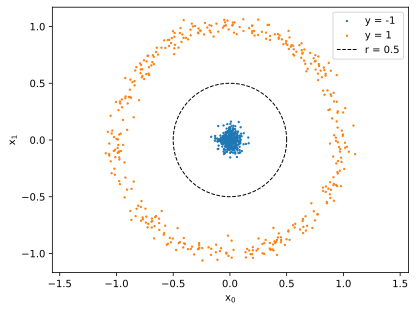

In [34]:
import matplotlib.pyplot as plt

def plot_dataset(x_neg, x_pos):
    m = len(x_neg)
    limit = m // 10
    plt.scatter(x_neg[:limit, 0], x_neg[:limit, 1], s=2.0, color="C0", label="y = -1")
    plt.scatter(x_pos[:limit, 0], x_pos[:limit, 1], s=2.0, color="C1", label="y = 1")
    plt.plot(x0, x1, color='black', linewidth=1, linestyle='dashed', label="r = 0.5")
    plt.xlabel("x$_0$")
    plt.ylabel("x$_1$")
    plt.legend()
    plt.axis('equal');

plot_dataset(x_neg, x_pos)

Note that radius less than 0.5 determines the label as negative (with high probability):

In [35]:
# 2x - 1: [0, 1] -> [-1, 1] 
((2 * (torch.sqrt((x ** 2).sum(dim=1)) >= 0.5).float() - 1).numpy() == y_true).mean()

1.0

We use this to write simulated LFs with given parameters:

In [36]:
def lf_sim(coverage, accuracy):
    def predict(x):
        m = x.shape[0]
        cov_mask = torch.rand(m) < coverage
        acc_mask = torch.tensor(np.random.choice([-1, 1], size=sum(cov_mask).item(), p=[1 - accuracy, accuracy]))
        y = 2 * (torch.sqrt((x ** 2).sum(dim=1)) >= 0.5).long() - 1
        y[cov_mask == 0] = 0
        y[cov_mask == 1] *= acc_mask
        return y
    return predict

# example
p = lf_sim(0.3, 0.8)(x).numpy()
print("cov: ", (p != 0).mean())
print("acc: ", (p[p != 0] == y_true[p != 0]).mean())
print("acc+:", (p[(p != 0) & (y_true == +1)] == y_true[(p != 0) & (y_true == +1)]).mean())
print("acc-:", (p[(p != 0) & (y_true == -1)] == y_true[(p != 0) & (y_true == -1)]).mean())

cov:  0.2974
acc:  0.8012777404169469
acc+: 0.8032511210762332
acc-: 0.7983193277310925


Initializing the empirical LF matrix. Some have fairly low accuracy:

In [37]:
import pandas as pd
lf_params = [(0.30, 0.75), (0.50, 0.65), (0.40, 0.70), (0.20, 0.80), (0.25, 0.90)]
labeling_funcs = [lf_sim(*param) for param in lf_params]

df = pd.DataFrame({"y": y_true})
df["x0"] = x[:, 0].numpy()
df["x1"] = x[:, 1].numpy()
for j, lf in enumerate(labeling_funcs):
    df[f"LF{j + 1}"] = lf(x).int().numpy()

print(df.shape)
df.head()

(10000, 8)


y        x0        x1  LF1  LF2  LF3  LF4  LF5
0  1 -0.013268 -1.021874   -1   -1    0    0    0
1  1 -0.162512  1.006516    0    1    1    0    0
2 -1  0.003852  0.141634    0    0    0    0    0
3 -1 -0.024912  0.002939   -1    0    0    0    0
4 -1  0.058476 -0.078667    0    0    0    0    0

Splitting for evaluation:

In [38]:
# 80-20
SPLIT_RATIO = 0.80
m = x.shape[0]
x_train = x[:int(SPLIT_RATIO * m)]
x_valid = x[int(SPLIT_RATIO * m):]
y_train = torch.tensor(y_true[:int(SPLIT_RATIO * m)])
y_valid = torch.tensor(y_true[int(SPLIT_RATIO * m):])

#### Model training

In [39]:
from tqdm.notebook import tqdm


class GenModel:
    def __init__(self, labeling_funcs: list, label_probs: dict):
        self.lfs = labeling_funcs
        self.py = torch.tensor([0.0, label_probs[1], label_probs[-1]])  # zero-index = dummy
        self.params = None

    def loss_fn(self, L):
        p_pos = self.infer_joint_proba(L, +1)
        p_neg = self.infer_joint_proba(L, -1)
        p = p_pos + p_neg   # Note: p has shape [m,]
        return -torch.log(p).mean()

    def fit(self, x_train, x_valid=None, bs=32, epochs=1, lr=0.0001, lr_decay=1.0):
        """MLE estimate of coverage and accuracy parameters of LFs."""
        L_train = self.lf_outputs(x_train)
        L_valid = self.lf_outputs(x_valid) if x_valid is not None else None
        m, n = L_train.shape

        delta = torch.randn(n, requires_grad=True)  # coverage score
        gamma = torch.randn(n, requires_grad=True)  # accuracy score
        delta.retain_grad()
        gamma.retain_grad()

        history = {"train": [], "valid": [], "valid_steps": []}
        checkpoint = (None, np.inf)

        try:
            for e in tqdm(range(epochs)):
                B = torch.randperm(m)
                for i in range(m // bs):
                    batch = B[i * bs: (i + 1) * bs]

                    # Note: weights are scores => need to convert to probs (p = σ(w))
                    p_delta = 1. / (1. + torch.exp(-delta))
                    p_gamma = 1. / (1. + torch.exp(-gamma))
                    self.params = torch.stack([
                        1 - p_delta,                # abstained
                        p_delta * p_gamma,          # accurate
                        p_delta * (1 - p_gamma)     # inaccurate
                    ], dim=0)

                    loss = self.loss_fn(L_train[batch])
                    loss.backward(retain_graph=True)

                    with torch.no_grad():
                        delta -= lr * (lr_decay ** (e / epochs)) * delta.grad
                        gamma -= lr * (lr_decay ** (e / epochs)) * gamma.grad
                        delta.grad = None
                        gamma.grad = None

                    history["train"].append(loss.item())
                
                with torch.no_grad():
                    if L_valid is not None:
                        val_loss = self.loss_fn(L_valid)
                        history["valid"].append(val_loss.item())
                        history["valid_steps"].append((e + 1) * (m // bs))
                        if val_loss.item() < checkpoint[1]:
                            checkpoint = (self.params, val_loss.item())

        except KeyboardInterrupt:
            print("Training stopped.")

        finally:
            # Note: model is agnostic to relabeling. Row swap when model confuses +1 and -1.
            self.params = checkpoint[0]
            if (self.params[1, :] / (1 - self.params[0, :])).mean() < 0.5:
                row_swap = torch.tensor([[1, 0, 0], [0, 0, 1], [0, 1, 0]]).float()
                self.params = row_swap @ self.params
            
            return history
    
    def predict(self, x):
        """Label inference using p(y | Λ_i)."""
        L = self.lf_outputs(x)
        p = self.target_cond_proba(+1, L) >= 0.5
        return 2 * p.long() - 1
    
    def target_cond_proba(self, y, L):
        """Estimate of target prob given LF observations, i.e. p(y | Λ)."""
        p_neg = self.infer_joint_proba(L, -1)            # p(Λ_i, y=-1)
        p_pos = self.infer_joint_proba(L, +1)            # p(Λ_i, y=+1)
        p_tot = p_neg + p_pos                            # p(Λ_i) for i = 1, ..., m
        return self.infer_joint_proba(L, y) / p_tot      # p(y | Λ_i) = p(Λ_i, y) / p(Λ_i)
    
    def infer_joint_proba(self, L, y: int):
        """Return the estimated joint proba p(Λ_i, y), i.e. the output has shape [m,]."""
        n = L.shape[1]
        return self.py[y] * self.params[y * L, torch.arange(n)].prod(dim=1)     # p(Λ_i, y) = p(Λ_i | y) p(y)
    
    def lf_outputs(self, x):
        """Construct Λ matrix from LFs."""
        L = torch.stack([lf(x) for lf in self.lfs], dim=1)
        return L.long()


gen_model = GenModel(labeling_funcs, LABEL_PROBS)
history = gen_model.fit(x_train, x_valid, bs=4096, epochs=35000, lr=0.03, lr_decay=0.8)

  0%|          | 0/35000 [00:00<?, ?it/s]

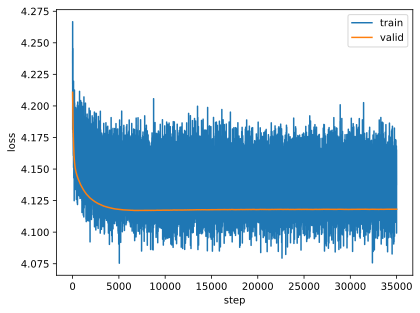

In [40]:
plt.plot(history["train"], label="train")
plt.plot(history["valid_steps"], history["valid"], label="valid")
plt.ylabel("loss")
plt.xlabel("step")
plt.legend();

In [41]:
print("latent:")
print([f"{cov:.4f}" for cov, acc in lf_params])
print([f"{acc:.4f}" for cov, acc in lf_params])

latent:
['0.3000', '0.5000', '0.4000', '0.2000', '0.2500']
['0.7500', '0.6500', '0.7000', '0.8000', '0.9000']


Model is able to learn the latent probabilities:

In [42]:
print("estimate:")
print([f"{cov:.4f}" for cov in (1 - gen_model.params[0, :]).tolist()])
print([f"{acc:.4f}" for acc in (gen_model.params[1, :] / (1 - gen_model.params[0, :])).tolist()])

estimate:
['0.2937', '0.4958', '0.3978', '0.1937', '0.2581']
['0.7563', '0.6655', '0.6700', '0.7918', '0.8129']


The trained model can be used to estimate joint probabilities of LF outputs and targets:

In [43]:
l = torch.tensor([[-1, -1, -1, -1, -1]])
print(gen_model.infer_joint_proba(l, +1).item())
print(gen_model.infer_joint_proba(l, -1).item())

1.8203746776634944e-06
0.00025144030223600566


The conditional probabilities of targets given LF outputs sum to 1:

In [44]:
# Simple test that the model learned (without using latent labels):
l = torch.tensor([[-1, -1, -1, -1, -1]])
print(gen_model.target_cond_proba(+1, l).item())
print(gen_model.target_cond_proba(-1, l).item())

0.007187750656157732
0.9928122162818909


#### Label inference

Soft labels can be generated for a test input using $p_{\hat{\theta}}(y \mid \lambda(\boldsymbol{\mathsf{x}}))$ calculated using learned LF parameters. This already takes into account the prior label distribution. In particular, if $\lambda(\boldsymbol{\mathsf{x}}) = \boldsymbol{0}$, then the model falls back to the prior label distribution. Evaluating using latent labels:

In [45]:
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import f1_score, confusion_matrix, precision_score, recall_score


def evaluate(model, x, y, t=None, verbose=True):
    m = x.shape[0]
    preds = model.predict(x) if t is None else model.predict(x, t)
    f1 = f1_score(y.numpy(), preds.numpy(), average="weighted")
    recall = recall_score(y.numpy(), preds.numpy(), average="weighted")
    precision = precision_score(y.numpy(), preds.numpy(), average="weighted")
    
    if verbose:
        print(confusion_matrix(y.numpy(), preds.numpy()))
    
    return {
        "f1": f1,
        "recall": recall,
        "precision": precision,
        "m": m, "message": f"m={m}, f1={f1:.5f}"
    }

print(evaluate(gen_model, x_train, y_train)["message"]); print()
print(evaluate(gen_model, x_valid, y_valid)["message"])

[[2016 1156]
 [ 823 4005]]
m=8000, f1=0.74990

[[533 287]
 [184 996]]
m=2000, f1=0.76153


### Noise-aware training

Noise-aware training amounts to weighting the loss with the estimate of the generative model for each target ${p_{\hat{\theta}}(y \mid \lambda(\boldsymbol{\mathsf{x}}))} = {p_{\hat{\theta}}(y, \lambda(\boldsymbol{\mathsf{x}}))}\, /\, {p_{\hat{\theta}}(\lambda(\boldsymbol{\mathsf{x}}))}.$ This allows us to train a model without labels:

In [46]:
import torch.nn as nn
from tempfile import NamedTemporaryFile
np.random.seed(42); torch.manual_seed(42)


class NoiseAwareTrainer:
    def __init__(self, clf, gen_model, labeling_funcs: list):
        self.clf = clf
        self.lfs = labeling_funcs
        self.gen_model = gen_model

    def loss_fn(self, L, x):
        with torch.no_grad():
            p_neg_cond = self.gen_model.target_cond_proba(-1, L)
            p_pos_cond = self.gen_model.target_cond_proba(+1, L)
            p = torch.concat([p_neg_cond, p_pos_cond], dim=0)
        
        fx = self.clf(x)
        s = torch.concat([-1 * fx, 1 * fx], dim=0)
        return (torch.log(1 + torch.exp(-s)) * p).mean()

    def run(self, x_train, x_valid=None, epochs=10, bs=8, lr=0.001, alpha=0.0, momentum=0.1):
        m = x_train.shape[0]
        history = {"train": [], "valid": [], "valid_steps": []}
        best_loss = np.inf
        best_epoch = 0
        optim = torch.optim.SGD(self.clf.parameters(), lr=lr, weight_decay=alpha, momentum=momentum)
        tmp = NamedTemporaryFile(suffix=".pt", delete=True)
        L_train = self.lf_outputs(x_train)
        L_valid = self.lf_outputs(x_valid) if x_valid is not None else None

        try: 
            for epoch in tqdm(range(epochs)):
                B = torch.randperm(m)
                for i in range(m // bs):
                    batch = B[i * bs: (i + 1) * bs]
                    loss = self.loss_fn(L_train[batch], x_train[batch])

                    # gradient step
                    loss.backward()
                    optim.step()
                    optim.zero_grad()

                    # callbacks
                    history["train"].append(loss.item())
                            
                    del loss
                    torch.cuda.empty_cache()
                
                with torch.no_grad():
                    if x_valid is not None:
                        val_loss = loss = self.loss_fn(L_valid, x_valid)
                        history["valid"].append(val_loss.item())
                        history["valid_steps"].append((epoch + 1) * (m // bs))
                        if val_loss < best_loss:
                            best_loss = val_loss.item()
                            best_epoch = epoch
                            torch.save(self.clf.state_dict(), tmp.name)

                if epoch - best_epoch > int(0.05 * epochs):
                    print(f"Early stopping at epoch {epoch}...")
                    raise KeyboardInterrupt

        except KeyboardInterrupt:
            print("Training stopped.")

        finally:
            print(f"Best valid loss: {best_loss}")
            self.clf.load_state_dict(torch.load(tmp.name))
            return history
    
    def lf_outputs(self, x):
        L = torch.stack([lf(x) for lf in self.lfs], dim=1).long()
        return L

    @torch.no_grad()
    def predict_proba(self, x):
        s = self.clf(x).view(-1)
        return 1 / (1 + torch.exp(-s))

    @torch.no_grad()
    def predict(self, x, t=0.0):
        s = self.clf(x).view(-1)
        return 2 * (s > t).long() - 1


clf = nn.Sequential(nn.Linear(2, 8), nn.SELU(), nn.Linear(8, 1))
trainer = NoiseAwareTrainer(clf, gen_model, labeling_funcs=labeling_funcs)
history = trainer.run(x_train, x_valid, epochs=120, bs=32, lr=0.003, alpha=0.0, momentum=0.1)

  0%|          | 0/120 [00:00<?, ?it/s]

Best valid loss: 0.34659144282341003


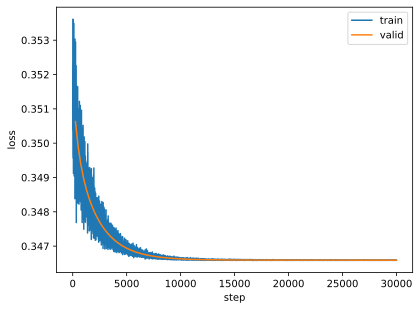

In [47]:
plt.plot(history["train"], label="train")
plt.plot(history["valid_steps"], history["valid"], label="valid")
plt.ylabel("loss")
plt.xlabel("step")
plt.legend();

In [48]:
print(evaluate(trainer, x_train, y_train, t=0.0)["message"]); print()
print(evaluate(trainer, x_valid, y_valid, t=0.0)["message"])

[[3172    0]
 [1008 3820]]
m=8000, f1=0.87529

[[820   0]
 [243 937]]
m=2000, f1=0.87937


The threshold for predicting hard labels can be calibrated by using the prior label distribution. This significantly improves F1. Here we use the entirety of our data (i.e. `x`):

In [49]:
from collections import Counter

calibration_score = [] # lower = better
thresholds = np.linspace(-1, 1, num=500)
for t in thresholds:
    c = Counter(trainer.predict(x, t).tolist())
    n = len(x)
    c[-1] = c[-1] / n 
    c[+1] = c[+1] / n 
    calibration_score.append(-LABEL_PROBS[-1] * np.log(c[-1]) + -LABEL_PROBS[+1] * np.log(c[+1]))


t_best = thresholds[np.argmin(calibration_score)]
print(evaluate(trainer, x_train, y_train, t=t_best)["message"]); print()
print(evaluate(trainer, x_valid, y_valid, t=t_best)["message"])

[[2615  557]
 [ 293 4535]]
m=8000, f1=0.89286

[[ 698  122]
 [  70 1110]]
m=2000, f1=0.90346


<br>

If we have a small but varied labeled subset of the data, then we can use that to tune the threshold. The following iteratively finds the threshold that maximizes weighted F1 on the validation set:

[[3172    0]
 [ 380 4448]]
m=8000, f1=0.95287

[[ 819    1]
 [  97 1083]]
m=2000, f1=0.95132


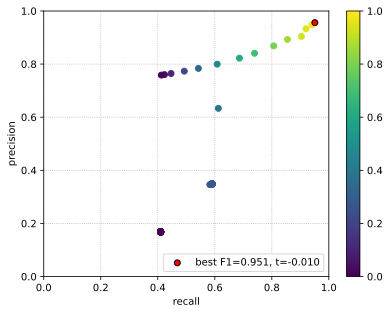

In [50]:
def pr_curve(model, x, y, num_thresholds, min_t=-1.0, max_t=1.0):
    p, r, t, f = [], [], [], []
    for threshold in np.linspace(min_t, max_t, num_thresholds):
        preds = model.predict(x, threshold).numpy()
        f.append(f1_score(y.numpy(), preds, average="weighted"))
        r.append(recall_score(y.numpy(), preds, average="weighted"))
        p.append(precision_score(y.numpy(), preds, average="weighted"))
        t.append(threshold)
    
    return p, r, t, f

def plot_pr_curve(model, x_valid, y_valid, num_thresholds=200, min_t=-1.0, max_t=1.0):
    """Tune threshold based on validation set."""
    p, r, t, f = pr_curve(model, x_valid, y_valid, num_thresholds, min_t, max_t);
    t_best_ = np.argmax(f)
    t_best = t[t_best_]

    # plotting the sample F1s
    plt.grid(linestyle="dotted", zorder=0)
    plt.scatter(r, p, c=f, zorder=2)
    plt.scatter(x=r[t_best_], y=p[t_best_], edgecolor="k", facecolor="red", label=f"best F1={f[t_best_]:.3f}, t={t_best:.3f}", zorder=3)
    plt.colorbar()
    plt.xlabel("recall")
    plt.ylabel("precision")
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.legend(loc="lower right")

    return t_best


# Fine tuning the threshold on small labeled data (i.e. x_valid):
t_best = plot_pr_curve(trainer, x_valid, y_valid, num_thresholds=500, min_t=-1.0, max_t=1.0)
print(evaluate(trainer, x_train, y_train, t=t_best)["message"]); print()
print(evaluate(trainer, x_valid, y_valid, t=t_best)["message"])

**Remark.** Model has learned fairly well despite having suboptimal LFs.

---

■